In [11]:
from transformers import ReformerConfig, ReformerTokenizer, ReformerModel, ReformerModelWithLMHead

tokenizer = ReformerTokenizer(vocab_file="configs/large_training_set_with_3000_tokenizer/spiece.model", do_lower_case=True, model_max_length=50000)
model = ReformerModelWithLMHead.from_pretrained('output/large_training_set_with_3000_tokenizer/checkpoint-38000')
model.eval()
model.cuda()
out = model.generate(tokenizer('m', return_tensors='pt')['input_ids'].cuda(), max_length=20)
tokenizer.decode(out.tolist()[0])


'mityqtwllclcqtgctqcptqcgqtsyclsytqqpye'

In [12]:
out = model.generate(tokenizer('m', return_tensors='pt')['input_ids'].cuda(), max_length=200)
tokenizer.decode(out.tolist()[0])

'mityqtwllclcqtgctqcptqcgqtsyclsytqqpyetqccccccccqnccqtsysyhsqnfqyesysysqqtqtsyqttqsyqtyesysyyenksysyyesyyeyeqtyeqtsysyqtqtqtyeqtqtsysysysysyyeyeyeyeyeyesysyyesyyeyeyeyeqtsytyyeyeyeyesysyyeyesyyesysyyesyyeyeyesysysyyesyyeyeyesysyyesyyeyeyeyesyyeyeyesysqyeyeqtyeyeqtsyyeqtyeyeyeyeyeyeyeyeyeyeyeyeyeqttytyyeyeyeyeyeyeyeyeqtyeyeyeyeyeyeyeyeyeyeqtyeyeyeyeyeyeyeyeyeyeyeyeyeqtyeyeqtqtqtyeyeqtyeyesysytqtq'

In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch


def prepare_dataset_for_tsne(file_paths, tokenizer, model):
    """
    file_paths: a list of .txt file_path:str
    return protein vectors numpy array: shape #proteins X #features
    """
    sequence_txt_list = []
    
    for file_path in file_paths:
        f = open(file_path, 'r')
        sequence_txt = f.readlines()
        f.close()
        sequence_txt_list.extend(sequence_txt)
        
    input_sequence_list = [tokenizer(sequence.strip(),
                                     truncation=True,
                                     return_tensors='pt')['input_ids'].cuda() for sequence in sequence_txt_list]
    model.cuda()
    protein_vectors_list = [torch.mean(model(inp)[1][-1], dim=1) for inp in input_sequence_list]
    protein_vectors = torch.cat(protein_vectors_list, dim = 0)
    protein_vectors_numpy = protein_vectors.to('cpu').numpy()
    del(protein_vectors_list); del(protein_vectors)
    
    return protein_vectors_numpy

def prepare_dataset_for_tsne_from_Dataframe(df, tokenizer, model):

    sequence_list = list(df.Sequence)
    input_sequence_list = [tokenizer(sequence.strip(),
                                     truncation=True,
                                     return_tensors='pt')['input_ids'].cuda() for sequence in sequence_list]
    model.cuda()
    protein_vectors_list = [torch.mean(model(inp)[1][-1], dim=1) for inp in input_sequence_list]
    protein_vectors = torch.cat(protein_vectors_list, dim = 0)
    protein_vectors_numpy = protein_vectors.to('cpu').numpy()
    del(protein_vectors_list); del(protein_vectors)

    return protein_vectors_numpy

def plot_tsne(features_array, n_comp=2):
    tsne_features = TSNE(n_components=n_comp).fit_transform(features_array)
    
    fig = plt.figure()
    
    ax = fig.add_subplot(111)
    
    ax.scatter(tsne_features[:,0], tsne_features[:,1], alpha=.5, edgecolors='w')
    
    plt.show()
    

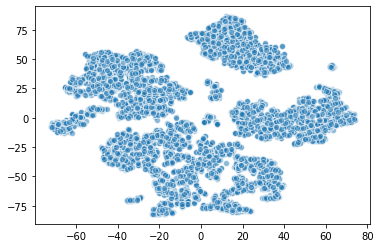

In [4]:
from transformers import ReformerConfig, ReformerTokenizer, ReformerModel, ReformerModelWithLMHead

MODEL_MAX_LENGTH = 2560
tokenizer = ReformerTokenizer(vocab_file="configs/alternative_tokenizer/alternative_tokenizer.model", do_lower_case=True, model_max_length=50000)
configuration = ReformerConfig.from_pretrained('configs/')
model = ReformerModelWithLMHead.from_pretrained('output/alternative_tokenizer/checkpoint-100000')
model.eval()
features_array = prepare_dataset_for_tsne(["data/yeast/yeast.txt"], tokenizer, model)
plot_tsne(features_array)

In [6]:
features_array.shape

(6049, 256)

In [13]:
import pandas as pd
df = pd.read_csv('data/yeast/yeast_modified.tab', sep='\t')
tokenizer = ReformerTokenizer(vocab_file="configs/alternative_tokenizer/alternative_tokenizer.model", do_lower_case=True, model_max_length=50000)
configuration = ReformerConfig.from_pretrained('configs/alternative_tokenizer/')
model_before_training = ReformerModelWithLMHead(configuration)
model_before_training.eval()
features_array_before_training = prepare_dataset_for_tsne_from_Dataframe(df, tokenizer=tokenizer, model=model_before_training)
tsne_features_before_training = TSNE(n_components=2).fit_transform(features_array_before_training)
tsne_df_before_training = pd.DataFrame.from_records(tsne_features_before_training, columns=['tsne_1', 'tsne_2'])
df_full_before_training = pd.concat([df, tsne_df_before_training], axis=1)

In [14]:
import pandas as pd
df = pd.read_csv('data/yeast/yeast_modified.tab', sep='\t')
tokenizer = ReformerTokenizer(vocab_file="configs/alternative_tokenizer/alternative_tokenizer.model", do_lower_case=True, model_max_length=50000)
model_after_training = ReformerModelWithLMHead.from_pretrained('output/alternative_tokenizer/checkpoint-100000')
model_after_training.eval()
features_array_after_training = prepare_dataset_for_tsne_from_Dataframe(df, tokenizer=tokenizer, model=model_after_training)
tsne_features_after_training = TSNE(n_components=2).fit_transform(features_array_after_training)
tsne_df_after_training = pd.DataFrame.from_records(tsne_features_after_training, columns=['tsne_1', 'tsne_2'])
df_full_after_training = pd.concat([df, tsne_df_after_training], axis=1)

In [15]:
import seaborn

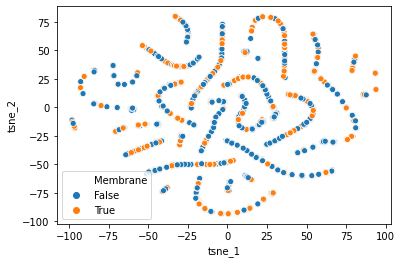

In [17]:
seaborn.scatterplot(x=df_full_before_training['tsne_1'], 
                    y=df_full_before_training['tsne_2'], 
                    hue=df_full_before_training['Membrane'])

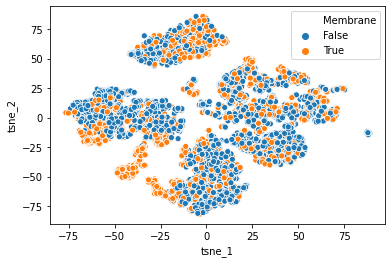

In [18]:
seaborn.scatterplot(x=df_full_after_training['tsne_1'], 
                    y=df_full_after_training['tsne_2'], 
                    hue=df_full_after_training['Membrane'])

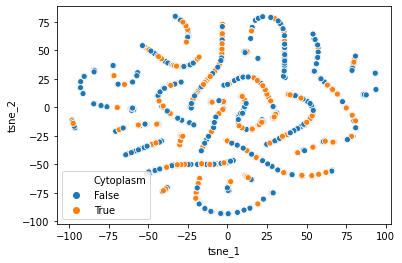

In [19]:
seaborn.scatterplot(x=df_full_before_training['tsne_1'], 
                    y=df_full_before_training['tsne_2'], 
                    hue=df_full_before_training['Cytoplasm'])

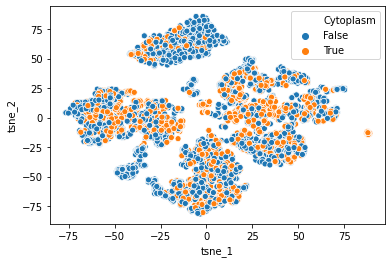

In [20]:
seaborn.scatterplot(x=df_full_after_training['tsne_1'], 
                    y=df_full_after_training['tsne_2'], 
                    hue=df_full_after_training['Cytoplasm'])

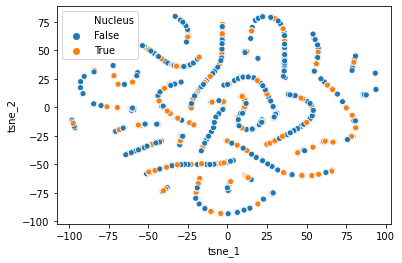

In [21]:
seaborn.scatterplot(x=df_full_before_training['tsne_1'], 
                    y=df_full_before_training['tsne_2'], 
                    hue=df_full_before_training['Nucleus'])

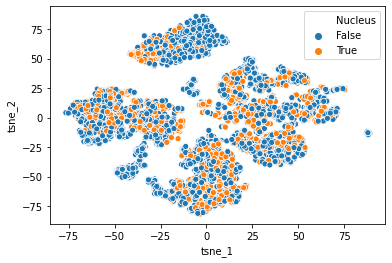

In [22]:
seaborn.scatterplot(x=df_full_after_training['tsne_1'], 
                    y=df_full_after_training['tsne_2'], 
                    hue=df_full_after_training['Nucleus'])

In [ ]:
tokenizer = ReformerTokenizer(vocab_file="configs/spiece.model", do_lower_case=True, model_max_length=MODEL_MAX_LENGTH)
configuration = ReformerConfig.from_pretrained('configs/alternative_tokenizer/')
model = ReformerModelWithLMHead(configuration)
model.eval()
df = pd.read_csv('data/yeast/yeast_modified.tab', sep='\t')
features_array = prepare_dataset_for_tsne_from_Dataframe(df, tokenizer=tokenizer, model=model)

In [ ]:
import pandas as pd
df = pd.read_csv('data/yeast/yeast_modified.tab', sep='\t')
tokenizer = ReformerTokenizer(vocab_file="configs/alternative_tokenizer/alternative_tokenizer.model", do_lower_case=True, model_max_length=50000)
model = ReformerModelWithLMHead.from_pretrained('output/alternative_tokenizer/')
model.eval()
features_array = prepare_dataset_for_tsne_from_Dataframe(df, tokenizer=tokenizer, model=model)
tsne_features = TSNE(n_components=2).fit_transform(features_array)
tsne_df = pd.DataFrame.from_records(tsne_features, columns=['tsne_1', 'tsne_2'])
df_full_before_training = pd.concat([df, tsne_df], axis=1)

In [9]:
df

,Entry,Entry name,Organism,Length,Mass,Gene ontology (biological process),Gene ontology (molecular function),Gene ontology (cellular component),Sequence,Cytoplasm,Nucleus,Mitochondrion,Endoplasmic,Golgi,Peroxisome,Endosome,Vacuole,Membrane
0,A0A023PYF4,YE145_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,145,"16,018",NaN,NaN,NaN,MAILLPLKSILPWCCITFSFLLSSSGSISHSTASSSITLTKSSKPT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A023PZB3,FMP49_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,126,"14,348",NaN,NaN,mitochondrion [GO:0005739],MYYFSRVAARTFCCCIFFCLATAYSRPDRNPRKIEKKDKKFFGASK...,False,False,True,False,False,False,False,False,False
2,A0A023PZE8,YD57W_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,133,"15,507",NaN,NaN,NaN,MSETCSSSLALLHKILHIHSHTPSVYYNICISVRILTSERLQCFFF...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A023PZF2,YE009_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,135,"15,939",NaN,NaN,NaN,MNTLLKKYRKQRYAWLRFLLFSKIEGSLPVALRILLSLQPFCCNIY...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A0A023PZG4,YL236_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,107,"11,596",NaN,NaN,NaN,MHTICLRSPIDESSPLPYKSIRQPLENAHSCQALCSLMAVLCASAA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6044,Q9ZZX0,AI5B_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,354,"42,279",intron homing [GO:0006314],endonuclease activity [GO:0004519],mitochondrion [GO:0005739],MLMLLMMILTNNKVFMETLYYYLMFNFQLMSPFGVPVPGPAPETKD...,False,False,True,False,False,False,False,False,False
6045,Q9ZZX1,SCE4_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,630,"72,165",aerobic respiration [GO:0009060]; electron tra...,cytochrome-c oxidase activity [GO:0004129]; en...,integral component of membrane [GO:0016021]; m...,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...,False,False,True,False,False,False,False,False,True
6046,Q9ZZX7,Q0032_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,96,"12,471",NaN,NaN,mitochondrion [GO:0005739],MLMMYMLFIMMKTYPMLSYHMMSYHIMLYTIMWYMKYSTYMRLWLL...,False,False,True,False,False,False,False,False,False
6047,Q9ZZX8,Q0017_YEAST,Saccharomyces cerevisiae (strain ATCC 204508 /...,53,"6,271",NaN,NaN,mitochondrion [GO:0005739],MCATYMFNITVIITHPTPTLRTRGPGFVRNRDLYIYKYKSNLINNL...,False,False,True,False,False,False,False,False,False


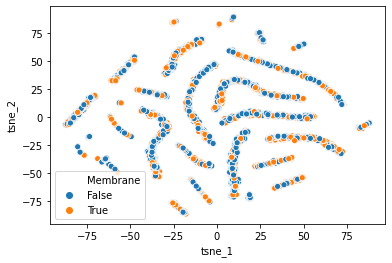

In [59]:
import seaborn
seaborn.scatterplot(x=df_full['tsne_1'], y=df_full['tsne_2'], hue=df_full['Membrane'])

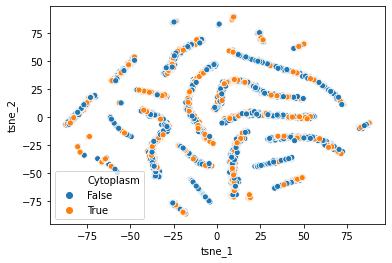

In [60]:
seaborn.scatterplot(x=df_full['tsne_1'], y=df_full['tsne_2'], hue=df_full['Cytoplasm'])

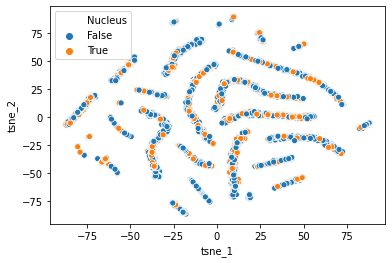

In [61]:
seaborn.scatterplot(x=df_full['tsne_1'], y=df_full['tsne_2'], hue=df_full['Nucleus'])

In [130]:
tokenizer = ReformerTokenizer(vocab_file="configs/spiece.model", do_lower_case=True, model_max_length=MODEL_MAX_LENGTH)
model = ReformerModel.from_pretrained('output/checkpoint-200000')
model.eval()
df = pd.read_csv('data/yeast/yeast_modified.tab', sep='\t')
features_array = prepare_dataset_for_tsne_from_Dataframe(df, tokenizer=tokenizer, model=model)
tsne_features = TSNE(n_components=2).fit_transform(features_array)
tsne_df = pd.DataFrame.from_records(tsne_features, columns=['tsne_1', 'tsne_2'])
df_full_trained = pd.concat([df, tsne_df], axis=1)


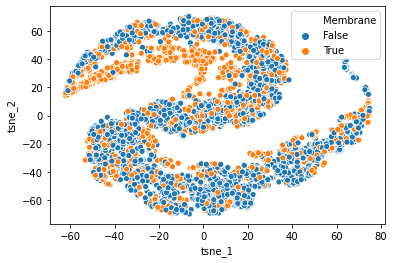

In [131]:
import seaborn
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Membrane'])

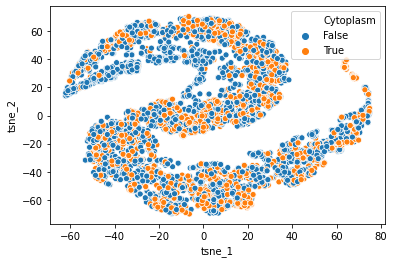

In [132]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Cytoplasm'])

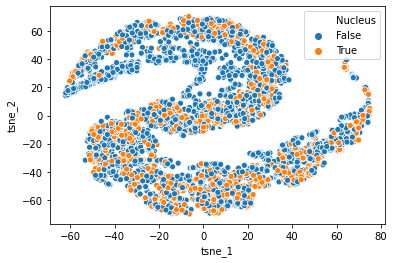

In [133]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Nucleus'])

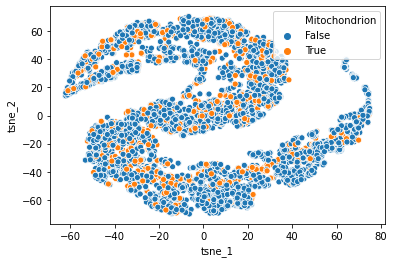

In [134]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Mitochondrion'])

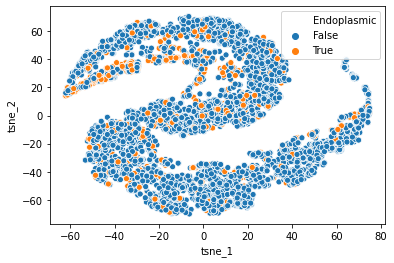

In [135]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Endoplasmic'])

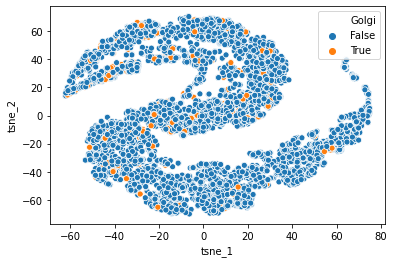

In [136]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Golgi'])

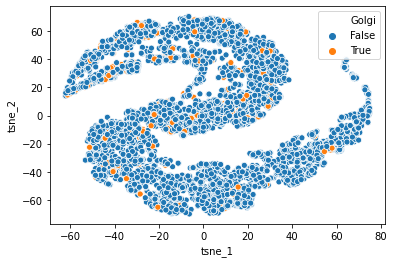

In [137]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Golgi'])

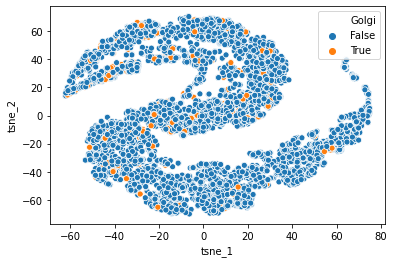

In [138]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Golgi'])

In [ ]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Golgi'])

In [ ]:
seaborn.scatterplot(x=df_full_trained['tsne_1'], y=df_full_trained['tsne_2'], hue=df_full_trained['Golgi'])

In [82]:
tokenizer = ReformerTokenizer(vocab_file="configs/spiece.model", do_lower_case=True, model_max_length=MODEL_MAX_LENGTH)
model1 = ReformerModelWithLMHead.from_pretrained('output/checkpoint-6000/')
model2 = ReformerModelWithLMHead.from_pretrained('output/checkpoint-200000')
model_1seq = ReformerModelWithLMHead.from_pretrained('output/checkpoint-500-1seq')

In [77]:
tokenizer('M', return_tensors='pt')

{'input_ids': tensor([[28,  9]]), 'attention_mask': tensor([[1, 1]])}

In [120]:
out = model2.generate(tokenizer('M', return_tensors='pt')['input_ids'], max_length=100)
tokenizer.decode(out.tolist()[0])

'mssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss'

In [121]:
out = model2.generate(tokenizer('MMMM', return_tensors='pt')['input_ids'], max_length=100)
tokenizer.decode(out.tolist()[0])

'mmmmksllsslssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss'

In [124]:
out = model2.generate(tokenizer('maillplksilpwccitfsf', return_tensors='pt')['input_ids'], max_length=100)
tokenizer.decode(out.tolist()[0])

'maillplksilpwccitfsflllllllllllllllllllllllllllllllllllllllllllllllllllsillllllllllllllllllllllllsl'

In [125]:
out = model1.generate(tokenizer('maillplksilpwccitfsf', return_tensors='pt')['input_ids'], max_length=100)
tokenizer.decode(out.tolist()[0])

'maillplksilpwccitfsflllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll'

In [103]:
model2.generate(tokenizer('<s>', return_tensors='pt')['input_ids'], max_length=100)

tensor([[28,  0, 12,  0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 12]])

In [100]:
tokenizer.decode(28)

''

In [101]:
model_1seq.generate(tokenizer('<s>', return_tensors='pt')['input_ids'], max_length=100)

tensor([[28,  0, 12,  0,  8,  8, 10,  8,  7, 12,  6,  8, 10, 14,  3,  3,  6, 13,
          4, 12,  4,  8,  8, 12, 12, 12, 18, 12,  6, 12,  5, 12, 13, 22, 12, 12,
         12,  6, 13,  8, 13,  7, 12, 12,  7, 10, 13, 19, 21, 10, 12, 19, 12, 24,
          4, 16,  3, 12, 13,  6, 19, 13,  4, 14,  8,  6, 21,  8, 12,  9, 13, 12,
          7, 18,  7,  6, 12, 18, 24,  8,  6,  8, 24, 22, 12, 21, 15, 22,  3, 17,
          3, 13,  3,  6, 24, 15, 22,  3,  3, 17]])

In [86]:
out = model_1seq.generate(tokenizer('M', return_tensors='pt')['input_ids'], max_length=100)

In [87]:
out

tensor([[28,  9, 22,  6,  8,  8, 10,  8,  7, 12,  6,  8, 10, 14,  3,  3,  6, 13,
          4, 12,  4,  8,  8, 12, 12, 12, 18, 12,  6, 12,  5, 12, 13, 22, 12, 12,
         12,  6, 13,  8, 13,  7, 12, 12,  7, 10, 13, 19, 21, 10, 12, 19, 12, 24,
          4, 16,  3, 12, 13,  6, 19, 13,  4, 14,  8,  6, 21,  8, 12,  9, 13, 12,
          7, 18,  7,  6, 12, 18, 24,  8,  6,  8, 24, 22, 12, 21, 15, 22,  3, 17,
          3, 13,  3,  6, 24, 15, 22,  3,  3, 17]])

In [97]:
tokenizer.decode(out.tolist()[0])

'maillplksilpwccitfsfllsssgsishstasssitltksskptnvpsnsrfdcstintfwlivlsmtskgkisgrlilrasvyacectciryacce'

In [ ]:
maillplksilpwccitfsfllsssgsishstasssitltksskptnvpsnsrfdcstintfwlivlsmtskgkisgrlilrasvyacectciryaccetiypprkpfslslyffyfnkkasilfcypdaktkpehpgnkragsg